# Final Project - Shawn Feng, Will Novak, Eddie Loyd

In [1]:
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from music21 import *
import random

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [29]:
#filenames = glob.glob('midi_data/*/**/*.mid', recursive=True)
#filenames = glob.glob('maestro-v3.0.0/**/*.mid*', recursive=True)
#sample_file = filenames[1]  # Change this to the desired MIDI file
#sample_file = "midi_data\progressions\I-VI-ii-V-maj\A-5-I-VI-ii-V-maj-46.mid"
#sample_file = "midi_data\scales\ionian\G-4ionian-4.mid"
sample_file = "maestro-v3.0.0\\2008\MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--3.midi"
#sample_file = "G_major.mid"
sample_file

'maestro-v3.0.0\\2008\\MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--3.midi'

In [30]:
pm = pretty_midi.PrettyMIDI(sample_file)
print(pm)

In [46]:
#b = converter.parse("midi_data\scales\ionian\G-4ionian-0.mid")
b = converter.parse("G_major.mid")
sp = midi.realtime.StreamPlayer(b)
#sp.play()

In [47]:
#sp.stop()

In [48]:
#b = converter.parse("maestro-v3.0.0\\2008\MIDI-Unprocessed_09_R1_2008_01-05_ORIG_MID--AUDIO_09_R1_2008_wav--3.midi")
#sp = midi.realtime.StreamPlayer(b)
#sp.play()

In [31]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [32]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()
raw_notes

,pitch,start,end,step,duration
0,63,1.026042,1.179688,0.000000,0.153646
1,75,1.046875,1.227865,0.020833,0.180990
2,75,1.545573,1.721354,0.498698,0.175781
3,63,1.582031,1.670573,0.036458,0.088542
4,75,1.960938,2.645833,0.378906,0.684896
...,...,...,...,...,...
4244,87,271.924479,272.337240,0.011719,0.412760
4245,68,271.930990,273.162760,0.006510,1.231771
4246,80,271.938802,272.406250,0.007812,0.467448
4247,71,271.953125,273.113281,0.014323,1.160156


In [6]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F#4', 'G4', 'A4', 'B4'],
      dtype='<U3')

In [7]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

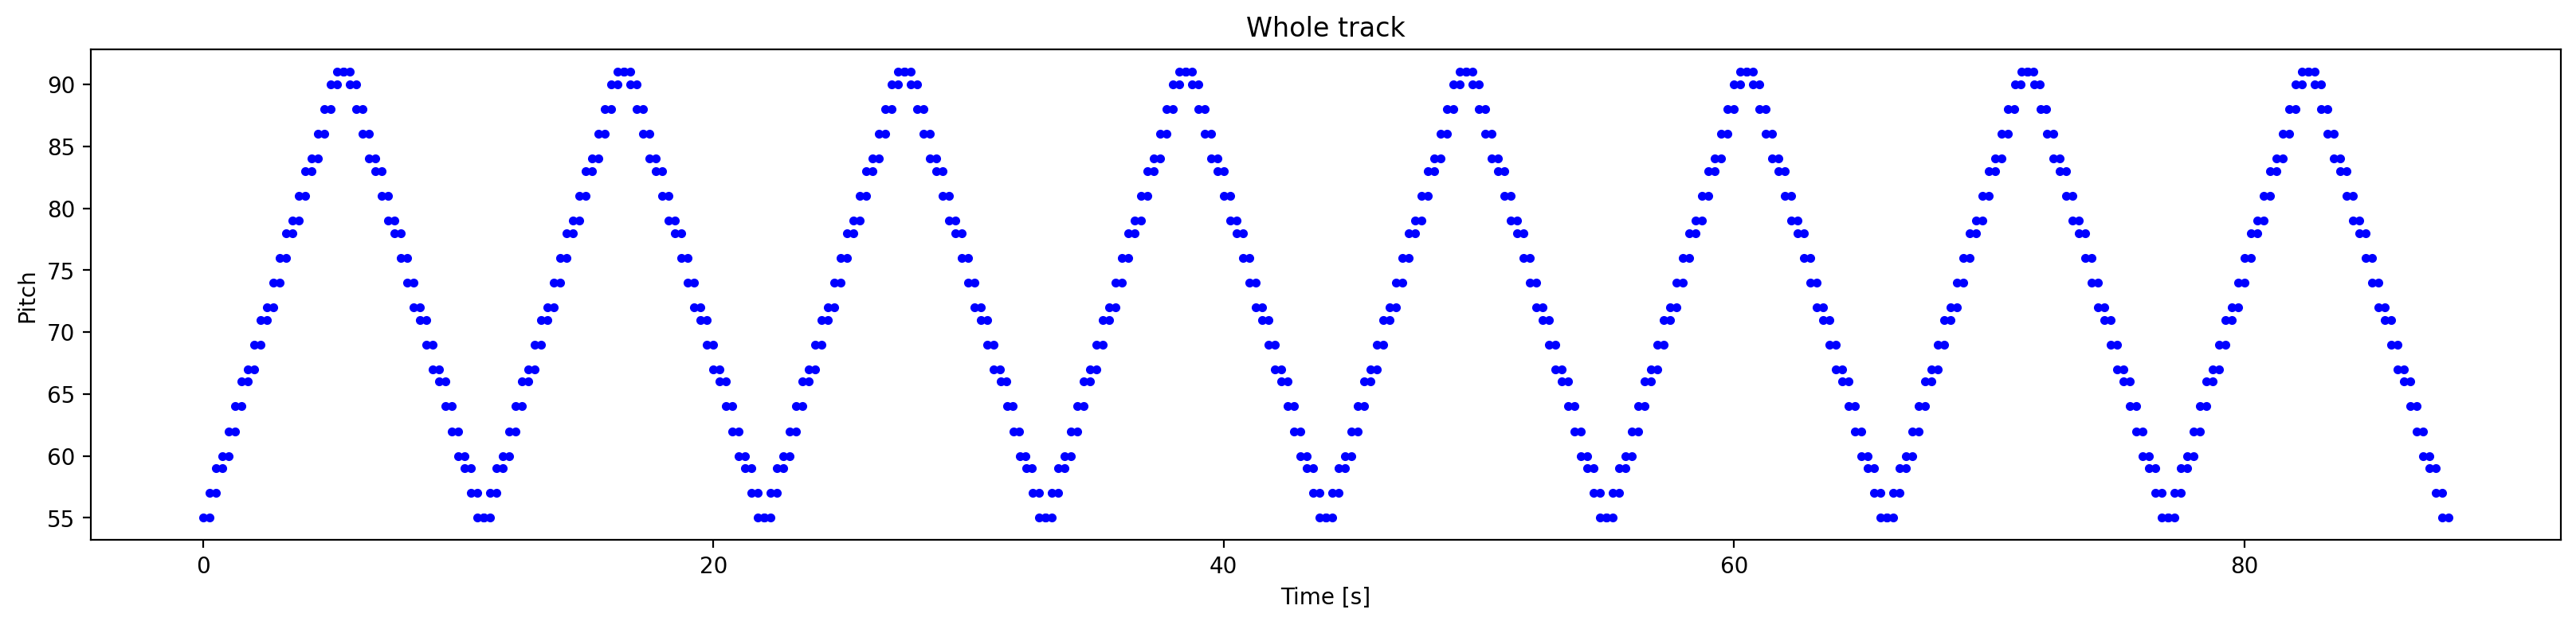

In [8]:
plot_piano_roll(raw_notes)

In [113]:
random.shuffle(filenames)

In [114]:
num_files = 10
all_notes = []
for f in filenames[:num_files]:
    try:
        notes = midi_to_notes(f)
        all_notes.append(notes)
    except:
        print(f)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
n_notes

45403

In [9]:
all_notes = []
for i in range(1):
    notes = midi_to_notes("G_major.mid")
    all_notes.append(notes)
all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
n_notes

C:\Users\shawn\miniconda3\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


352

In [10]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
train_notes

array([[55.        ,  0.        ,  0.24895833],
       [57.        ,  0.25      ,  0.24895833],
       [59.        ,  0.25      ,  0.24895833],
       ...,
       [59.        ,  0.25      ,  0.24895833],
       [57.        ,  0.25      ,  0.24895833],
       [55.        ,  0.25      ,  0.24895833]])

In [11]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [12]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,
                                drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [14]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            #.shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [15]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [16]:
input_shape = (seq_length, 3)
learning_rate = 0.005

# inputs = tf.keras.Input(input_shape)
# x = tf.keras.layers.LSTM(128)(inputs)

# outputs = {
#     'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
#     'step': tf.keras.layers.Dense(1, name='step')(x),
#     'duration': tf.keras.layers.Dense(1, name='duration')(x),
# }

# model = tf.keras.Model(inputs, outputs)

inputs = tf.keras.Input(input_shape)
lstm = tf.keras.layers.LSTM(512)(inputs)
drop = tf.keras.layers.Dropout(0.25)(lstm)
dense = tf.keras.layers.Dense(256)(drop)
outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(dense),
    'step': tf.keras.layers.Dense(1, name='step')(dense),
    'duration': tf.keras.layers.Dense(1, name='duration')(dense),
}

model = tf.keras.Model(inputs, outputs)

loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 1.0,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 512)                  1056768   ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 512)                  0         ['lstm[0][0]']                
                                                                                                  
 dense (Dense)               (None, 256)                  131328    ['dropout[0][0]']             
                                                                                              

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [18]:
%%time
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
4/4 [==============================] - 13s 2s/step - loss: 9.1193 - duration_loss: 4.0649 - pitch_loss: 4.7973 - step_loss: 0.2571
Epoch 2/100
4/4 [==============================] - 3s 770ms/step - loss: 44.2326 - duration_loss: 38.7201 - pitch_loss: 5.2575 - step_loss: 0.2549
Epoch 3/100
4/4 [==============================] - 3s 780ms/step - loss: 4.7241 - duration_loss: 0.0490 - pitch_loss: 4.6723 - step_loss: 0.0028
Epoch 4/100
4/4 [==============================] - 3s 778ms/step - loss: 4.6016 - duration_loss: 0.0295 - pitch_loss: 4.5700 - step_loss: 0.0021
Epoch 5/100
4/4 [==============================] - 3s 771ms/step - loss: 6.5828 - duration_loss: 2.1656 - pitch_loss: 4.3660 - step_loss: 0.0512
Epoch 6/100
4/4 [==============================] - 3s 785ms/step - loss: 4.9205 - duration_loss: 0.9113 - pitch_loss: 3.9925 - step_loss: 0.0166
Epoch 7/100
4/4 [==============================] - 3s 772ms/step - loss: 4.4593 - duration_loss: 0.7870 - pitch_loss: 3.6208 - ste

4/4 [==============================] - 3s 704ms/step - loss: 3.0369 - duration_loss: 0.0033 - pitch_loss: 3.0329 - step_loss: 7.6571e-04
Epoch 58/100
4/4 [==============================] - 3s 697ms/step - loss: 3.0301 - duration_loss: 0.0035 - pitch_loss: 3.0258 - step_loss: 8.2526e-04
Epoch 59/100
4/4 [==============================] - 3s 695ms/step - loss: 3.0290 - duration_loss: 0.0034 - pitch_loss: 3.0247 - step_loss: 9.0862e-04
Epoch 60/100
4/4 [==============================] - 3s 717ms/step - loss: 3.0244 - duration_loss: 0.0032 - pitch_loss: 3.0202 - step_loss: 9.2953e-04
Epoch 61/100
4/4 [==============================] - 3s 730ms/step - loss: 3.0124 - duration_loss: 0.0036 - pitch_loss: 3.0080 - step_loss: 7.6470e-04
Epoch 62/100
4/4 [==============================] - 3s 748ms/step - loss: 3.0078 - duration_loss: 0.0029 - pitch_loss: 3.0040 - step_loss: 8.8643e-04
Epoch 63/100
4/4 [==============================] - 3s 724ms/step - loss: 2.9953 - duration_loss: 0.0029 - pitch_

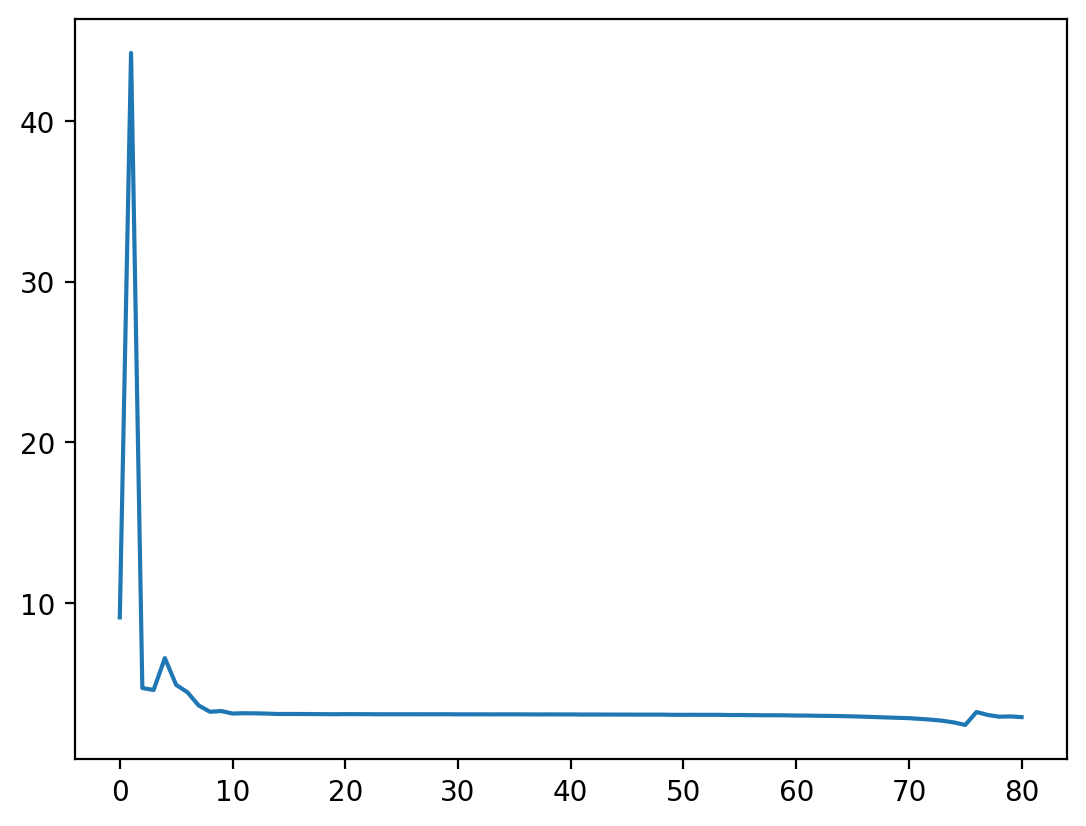

In [19]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [20]:
def predict_next_note(
        notes: np.ndarray, 
        model: tf.keras.Model, 
        temperature: float = 1.0) -> tuple[int, float, float]:
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [22]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([all_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

In [23]:
input_notes.shape

(50, 3)

In [24]:
generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
        generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 95ms/step


In [25]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,61,0.209999,0.259102,0.209999,0.469101
1,83,0.060308,0.000000,0.270307,0.270307
2,83,0.029022,0.000000,0.299329,0.299329
3,84,0.036309,0.000000,0.335638,0.335638
4,84,0.029109,0.000000,0.364747,0.364747
5,84,0.025234,0.000000,0.389981,0.389981
6,84,0.020574,0.000000,0.410555,0.410555
7,84,0.016362,0.000000,0.426917,0.426917
8,91,0.012300,0.000000,0.439217,0.439217
9,84,0.014977,0.000000,0.454194,0.454194


In [26]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str, 
    instrument_name: str,
    velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [27]:
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
instrument_name

'Acoustic Grand Piano'

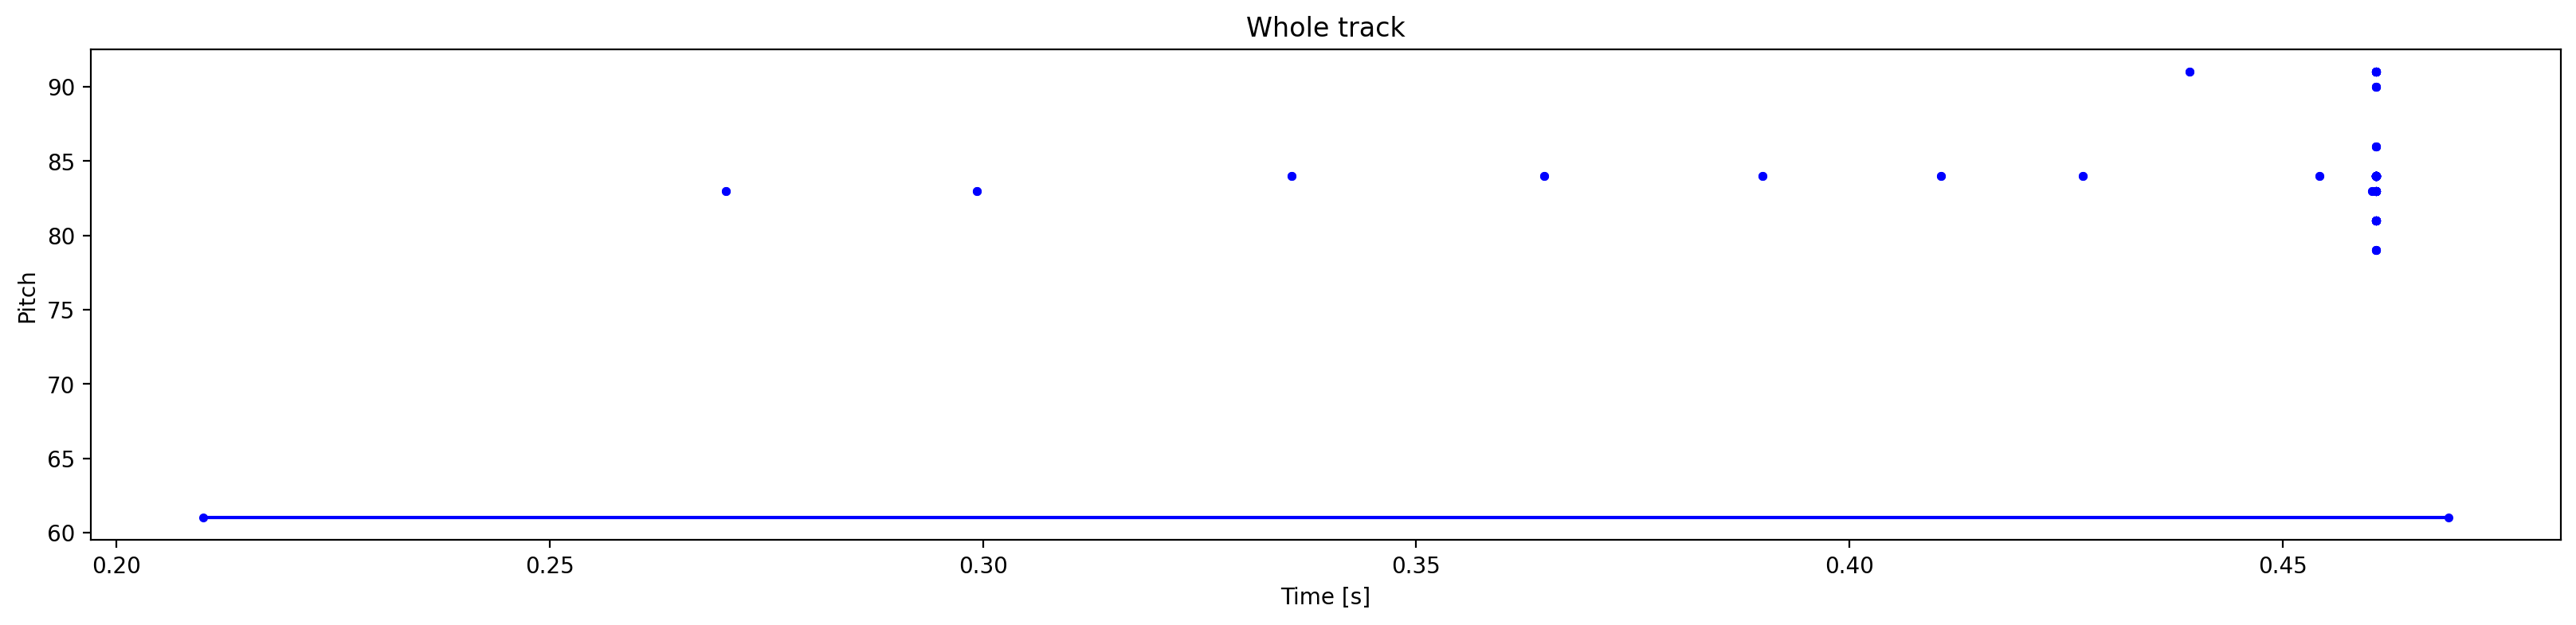

In [28]:
plot_piano_roll(generated_notes)

In [153]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file = out_file, instrument_name = instrument_name)
b = converter.parse('output.mid')
sp = midi.realtime.StreamPlayer(b)
sp.play()

In [141]:
sp.stop()

In [142]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

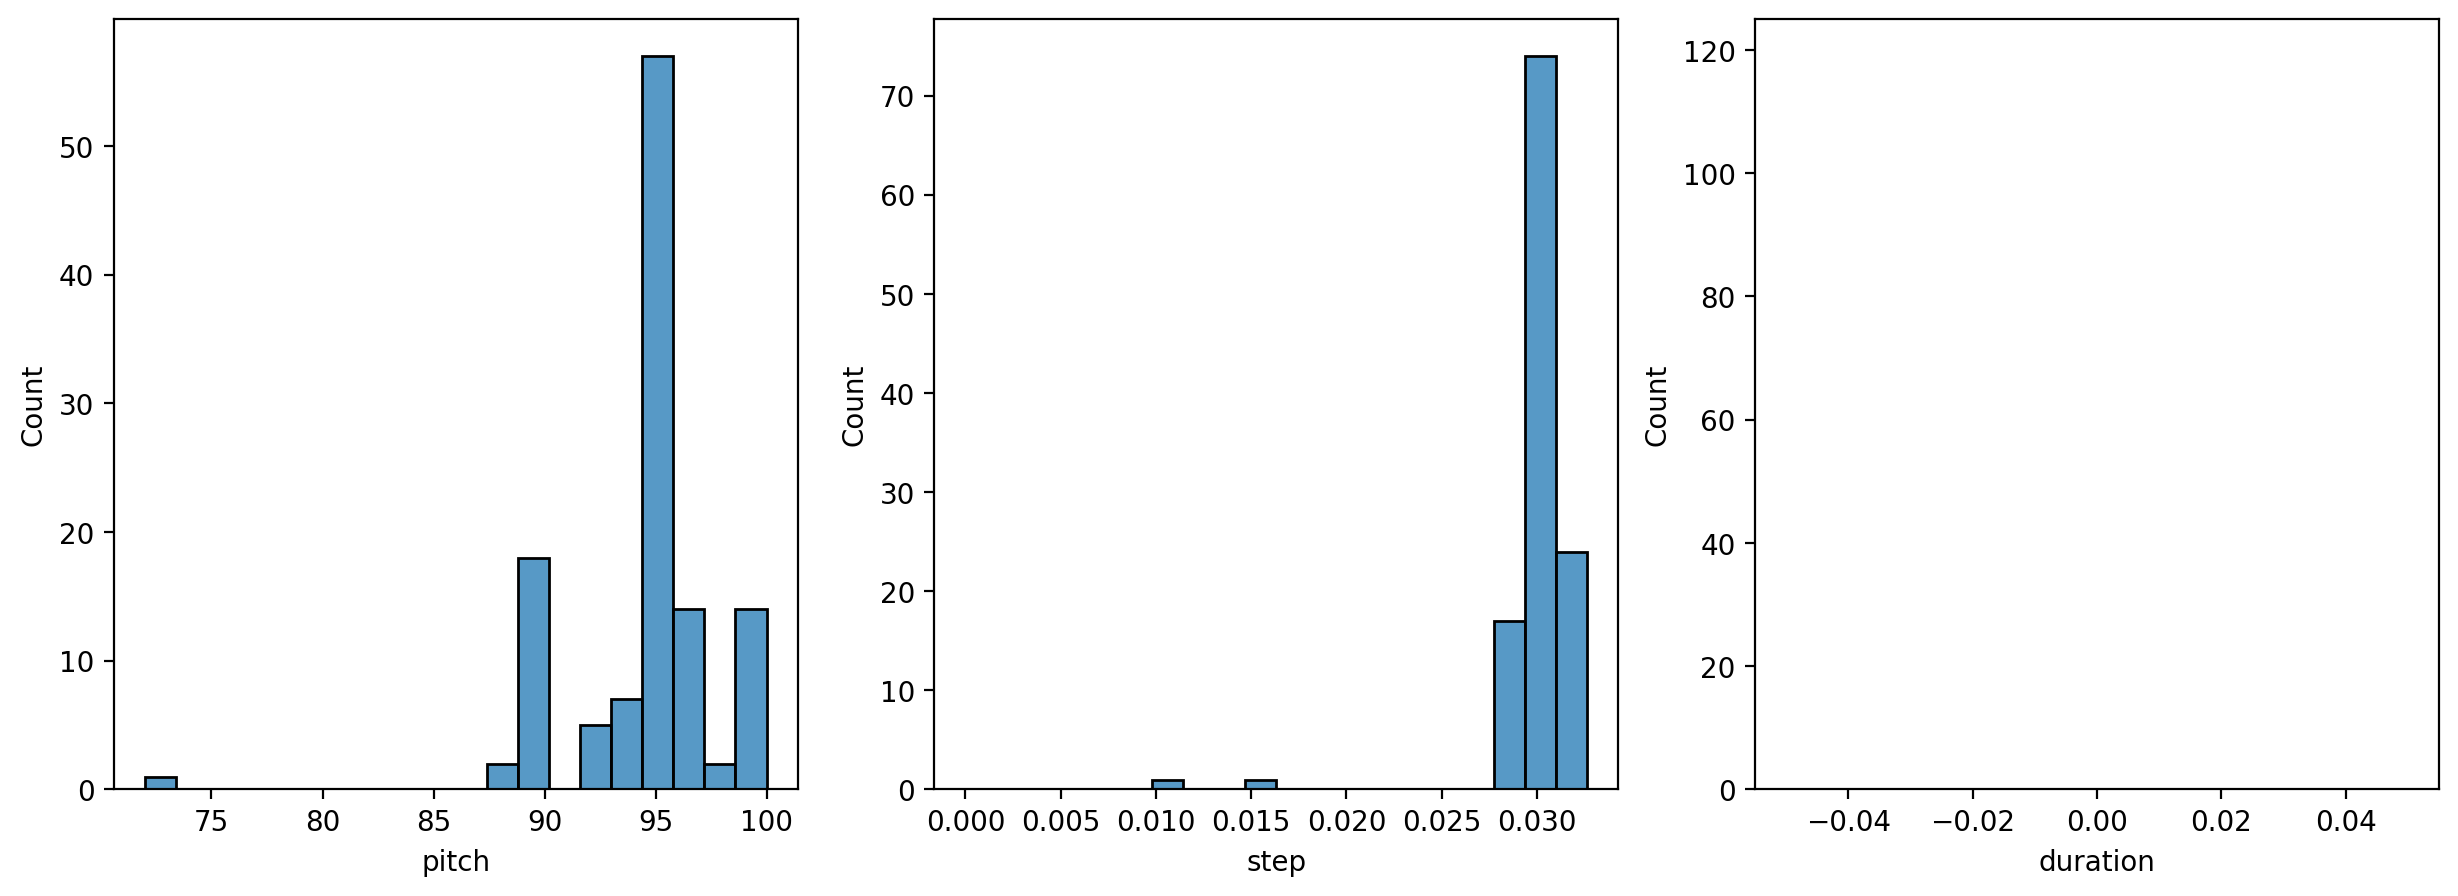

In [143]:
plot_distributions(generated_notes)

In [144]:
b = converter.parse("output.mid")
type(b)

music21.stream.base.Score

In [145]:
b.show()

SubConverterFileIOException: [23636:344:20231128,012715.614:ERROR process_info.cc:375] NtQuerySystemInformation SystemExtendedHandleInformation: The specified information record length does not match the length required for the specified information class. (0xc0000004)
[23636:22444:20231128,012715.632:ERROR filesystem_win.cc:129] GetFileAttributes C:/Users/shawn/AppData/Local/MuseScore/MuseScore4/logs/dumps\attachments\6cb9e2eb-b17a-49fd-b0d1-19ca2d4b5ba2: The system cannot find the file specified. (2)
